In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
import time

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
%cd "/content/gdrive/MyDrive/projet impression 3d"
!pwd

/content/gdrive/MyDrive/projet impression 3d
/content/gdrive/MyDrive/projet impression 3d


https://drive.google.com/drive/folders/1_MU7jTR0kTt8MFQYrUzWiWc6uM-BHG_9?usp=drive_link

#multi classes-----------------------------

In [4]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (255, 255))  # Assurez-vous que la taille correspond à celle utilisée lors de l'entraînement
    img = img / 255.0  # Normalisez les valeurs des pixels
    img = np.expand_dims(img, axis=0)  # Ajoutez une dimension pour représenter le lot (batch)

    return img

def predict_defect(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)

    # Interprétez la prédiction (1 signifie "OK", 0 signifie "défaut")
    if prediction[0, 0] > 0.5:
        return "OK"
    else:
        return "Défaut"


In [5]:
def load_data_multi_class(dataset_path):
    data = []
    labels = []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):

            label = folder.lower()  # Utilisez le nom du dossier comme label
            print(label)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (255, 255))
                data.append(img)
                labels.append(label)

    data = np.array(data) / 255.0
    labels = np.array(labels)

    return data, labels

In [6]:
!pwd

/content/gdrive/MyDrive/projet impression 3d


In [7]:
dataset_path = 'dataset_colab'
data, labels = load_data_multi_class(dataset_path)

ok
bed_not_stick
spaghetti


In [8]:
# Définir un dictionnaire de mapping catégorie -> numéro
categorie_mapping = {

    "ok": 0,
    "bed_not_stick": 1,
    "spaghetti": 2
}

# Utiliser NumPy pour convertir les catégories en numéros
labels = np.array([categorie_mapping[c] for c in labels])

In [9]:
print(len(labels))
print(labels[-1])

422
2


In [10]:
combined_data = list(zip(data,labels))

# Mélangez la liste combinée
random.shuffle(combined_data)

# Divisez à nouveau la liste combinée en deux listes distinctes
data,labels = zip(*combined_data)

labels = np.array(labels)
data = np.array(data)
print (len(labels))
print(labels[-1])




422
0


In [11]:
drop_out = 0.3
model = keras.Sequential([
    layers.Conv2D(64, (7, 7), activation='relu', input_shape=(255, 255, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(drop_out),  # Ajout d'une autre couche Dropout
    layers.Dense(64, activation='relu'),
    layers.Dropout(drop_out),  # Ajout d'une autre couche Dropout
    layers.Dense(32, activation='relu'),
    layers.Dropout(drop_out),  # Ajout d'une autre couche Dropout
    layers.Dense(3, activation='softmax')  # Ajustez cela en fonction de votre nombre de classes
])



In [12]:
from keras.callbacks import ModelCheckpoint

# Définissez le callback de sauvegarde du modèle
#checkpoint = ModelCheckpoint('meilleur_modele.h5', monitor='val_accuracy', save_best_only=True)

# Compilez le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 121, 128)     131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 128)               5

In [13]:
# Entraînez le modèle avec des batches de taille 10 par epoch et sauvegardez le meilleur modèle
model.fit(data, labels, epochs=15, validation_split=0.20, batch_size=8) #, callbacks=[checkpoint]


Epoch 1/15
43/43 [==============================] - 17s 74ms/step - loss: 1.8915 - accuracy: 0.5015 - val_loss: 0.9481 - val_accuracy: 0.5647
Epoch 2/15
43/43 [==============================] - 2s 55ms/step - loss: 1.0140 - accuracy: 0.5223 - val_loss: 0.9467 - val_accuracy: 0.5647
Epoch 3/15
43/43 [==============================] - 2s 54ms/step - loss: 0.9926 - accuracy: 0.5341 - val_loss: 0.9446 - val_accuracy: 0.5647
Epoch 4/15
43/43 [==============================] - 2s 58ms/step - loss: 0.9704 - accuracy: 0.5312 - val_loss: 0.9851 - val_accuracy: 0.5765
Epoch 5/15
43/43 [==============================] - 2s 57ms/step - loss: 0.9268 - accuracy: 0.5668 - val_loss: 0.9397 - val_accuracy: 0.5765
Epoch 6/15
43/43 [==============================] - 2s 55ms/step - loss: 0.9308 - accuracy: 0.5697 - val_loss: 0.8780 - val_accuracy: 0.5765
Epoch 7/15
43/43 [==============================] - 2s 55ms/step - loss: 0.8170 - accuracy: 0.6291 - val_loss: 0.8255 - val_accuracy: 0.6588
Epoch 8/15
4

In [20]:
model.save('88-83.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
def predict_defect_multi_class(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    #print (model.predict(preprocessed_img))

    # Interprétez les prédictions
    class_labels = [ 'OK','bed_not_stick', 'spaghetti']
    predicted_class = class_labels[np.argmax(predictions)]

    return predicted_class

In [16]:
def predict(dir):
    resultf=""
    nb_total=0
    nb_positif=0
    for filename in os.listdir(dir):
        #print(filename)
        nb_total+=1

        result = predict_defect_multi_class(model, dir +"/" + filename)
        if result.upper()==dir[4:].upper():
            nb_positif+=1

        resultf= resultf + "prédiction pour"+ filename + " : "+ str(result) +"\n"

    print (resultf)
    print(str((nb_positif*100)/nb_total) + " % de précision")


In [17]:
predict("testok")

1/1 [==============================] - 0s 32ms/step
prédiction pourok.jpg : OK
prédiction pourspaghetti.jpg : OK
prédiction pourok3.jpg : OK
prédiction pourspaghetti2.jpeg : spaghetti
prédiction pourok4.jpg : OK
prédiction pourok5.png : spaghetti
prédiction pourWIN_20231010_15_02_24_Pro.jpg : OK
prédiction pourWIN_20231010_15_02_40_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_00_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_09_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_11_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_18_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_24_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_29_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_56_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_58_Pro.jpg : OK
prédiction pourWIN_20231010_15_04_02_Pro.jpg : OK
prédiction pourWIN_20231010_15_04_05_Pro.jpg : OK

88.88888888888889 % de précision


In [18]:
predict("testspaghetti")

1/1 [==============================] - 0s 24ms/step
prédiction pour149918_fea6b7ad1f911b19fff8646791e3edc9.jpg : spaghetti
prédiction pourcb7afa69396b8da7b092bcea0337193654a8ae99e3597e58851c8ba742c716e7_1.jpg : spaghetti
prédiction pourfailedprint2_img_5eb0af2d67ead.jpg : spaghetti
prédiction pourspaghetti_11_jpg.rf.8f8ab1a10807e3e51c4075a1a018ce3b.jpg : spaghetti
prédiction pourspaghetti_91_jpg.rf.2b147f68c7718049a4c11374c5f190be.jpg : spaghetti
prédiction pourimag-12-_jpg.rf.30b4d2d01cbe881c76ffb7cd4aa30d4c.jpg : spaghetti
prédiction pourDv-Hh80U0AABjlw_jpg.rf.6116d29abb60be092c1930f2765318db.jpg : spaghetti
prédiction pourspaghetti_52_jpg.rf.66888e51d1873df0cae0aaa48e07369f.jpg : OK
prédiction pourspaghetti_73_jpg.rf.5c6d77c9cee2ba4df4e3052c8e9ecdc3.jpg : spaghetti
prédiction pourspaghetti_70_jpg.rf.02d93e279aaca215b2131a0cc614507a.jpg : spaghetti
prédiction pourimag-33-_jpg.rf.b622576485c907754e8ec87e4e5360f8.jpg : spaghetti
prédiction pourspaghetti_46_jpg.rf.49d9ad2fa0574bc52cc150

In [46]:

import matplotlib.pyplot as plt

def vignette_random(dir):
  L=[]
  for filename in os.listdir(dir):
    L.append(filename)
  file_alea = L[random.randint(0, (len(L)-1))]
  image_path = dir +"/" + file_alea
  result = predict_defect_multi_class(model, image_path)
  img = Image.open(image_path)
  plt.imshow(img)
  plt.axis('off')  # Masquer les axes
  plt.show()

  print (result)


1/1 [==============================] - 0s 30ms/step


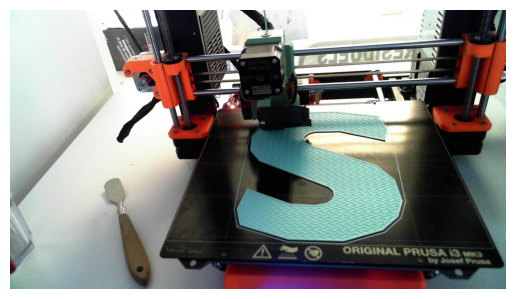

OK


In [73]:
vignette_random("testok")

1/1 [==============================] - 0s 26ms/step


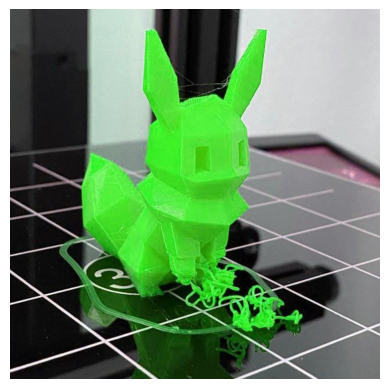

spaghetti


In [76]:
vignette_random("testspaghetti")

In [19]:
def capture():
  # Ouvrir la webcam (la webcam par défaut a l'ID 0)
  cap = cv2.VideoCapture(0)

  # Vérifier si la webcam est ouverte correctement
  if not cap.isOpened():
      print("Erreur: Impossible d'ouvrir la webcam.")
      exit()

  # Capturer une image
  time.sleep(1)
  ret, frame = cap.read()

  # Sauvegarder l'image capturée
  if ret:
      cv2.imwrite("photo_capturee.jpg", frame)
      print("Photo capturée avec succès.")
  else:
      print("Erreur lors de la capture de la photo.")

  # Libérer la webcam
  cap.release()
  time.sleep(1)


  result = predict_defect_multi_class(model, 'photo_capturee.jpg')
  print(f"Prédiction pour la capture camera: {result}")